# Second Approch

Importing libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
from sympy import Symbol
import copy as cp
import seaborn as sns
from scipy.linalg import cholesky
from math import sqrt
from numpy import shape

In this approch, the objectif is to use the modeling equation (1) of $H$, the water level of the watercourse, in order to minimize the overflow height, $S$, that is related to the physical variables and the height of the dike by the equation (2).

$H = {\left(\frac{Q}{K_s \sqrt(\frac{Z_m - Z_v}{L}) B}\right)}^{\frac{3}{5}} \ (1)$

$S = Z_c - Z_d = Zv + H - \mathcal{H}_d - Z_b \ (2) $

By the formulation of the problem, the major sources of uncertainty are considered to be the variables $Q$, $Z_m$, $Z_v$ and $K_s$. In this sense these variables are considered to be random variables with the following distributions :

$Q \sim Gumbel(1013, 558)$

$Z_m \sim Triangular(55, halfrange = 1)$

$Z_v \sim Triangular(50, halfrange = 1)$

$K_s \sim \mathcal{N}(30, 7.5)$

The other variables, $B$, $L$ and $Z_b$, are considered to be deterministics with values 300, 5000 and 55,5 respectively.

For the development that follows, it will be considered the 3 different scenarios:

1) Random variables without correlation

2) Correlation $K_s$-$Z_v$ of -0.6 and $Z_v$-$Z_m$ of 0.6

3) Correlation $K_s$-$Z_v$ of -0.3, $Z_v$-$Z_m$ of 0.66 and $K_s$-$Z_m$ of -0.5

-----

1) In this block it's generated 1 million samples of the random variables for the 3 scenarios and the constants variables are defined as well.

    It was considered that it doesn't make sense to have negative values of $Q$ and $K_s$ analysing their physical meaning in the model. But these variables follows porbabilistic laws that allows negative realisations. To solve this issue, when negative realisations of these variables occur, they are repeated until an positive values is obtained.

In [10]:
def PosNormal(mean, sigma):
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else PosNormal(mean,sigma))

def PosGumbel(mode, scale):
    x = np.random.gumbel(mode,scale)
    return(x if x>=0 else PosGumbel(mode,scale))

#n_sub_samples=len(Height)
def generate_sample(n=1000):
    sample=[]
    Q_a=np.array([PosGumbel(1013,558) for i in range(n)])
    k_sa=np.array([PosNormal(30,7.5) for i in range(n)])
    Z_va=np.array([np.random.triangular(49,50,51) for i in range(n)])
    Z_ma=np.array([np.random.triangular(54,55,56) for i in range(n)])
    sample=np.array([Q_a,k_sa,Z_va,Z_ma])
    return sample

In [38]:
n_sample=1000000
sample=generate_sample(n_sample)

#first scenario
q_realisations = sample[0]
ks_realisations = sample[1]
zv_realisations = sample[2]
zm_realisations = sample[3]
 
#second scenario
cov_matrix2 = np.array([
        [  1, -0.6, 0],
        [ -0.6,  1,  0.6],
        [ 0,  0.6,  1]
    ])

c2 = cholesky(cov_matrix2)

realisations_2 =np.zeros([q_realisations.shape[0],4])
for i in range(q_realisations.shape[0]):
    uncorrelated_var_i = [ks_realisations[i],zv_realisations[i],zm_realisations[i]]
    correlated_var_i = np.dot(c2,uncorrelated_var_i)
    realisations_2[i][:]=[q_realisations[i],correlated_var_i[0],correlated_var_i[1],correlated_var_i[2]]

#third scenario
cov_matrix3 = np.array([
        [  1, -0.3, -0.5],
        [ -0.3,  1,  0.66],
        [ -0.5,  0.66,  1]
    ])

c3 = cholesky(cov_matrix3)

realisations_3 = np.zeros([q_realisations.shape[0],4])
for i in range(q_realisations.shape[0]):
    uncorrelated_var_i = [ks_realisations[i],zv_realisations[i],zm_realisations[i]]
    correlated_var_i = np.dot(c3,uncorrelated_var_i)
    realisations_3[i][:]=[q_realisations[i],correlated_var_i[0],correlated_var_i[1],correlated_var_i[2]]


2) Histogram of the samples collected for the first scenario

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose l

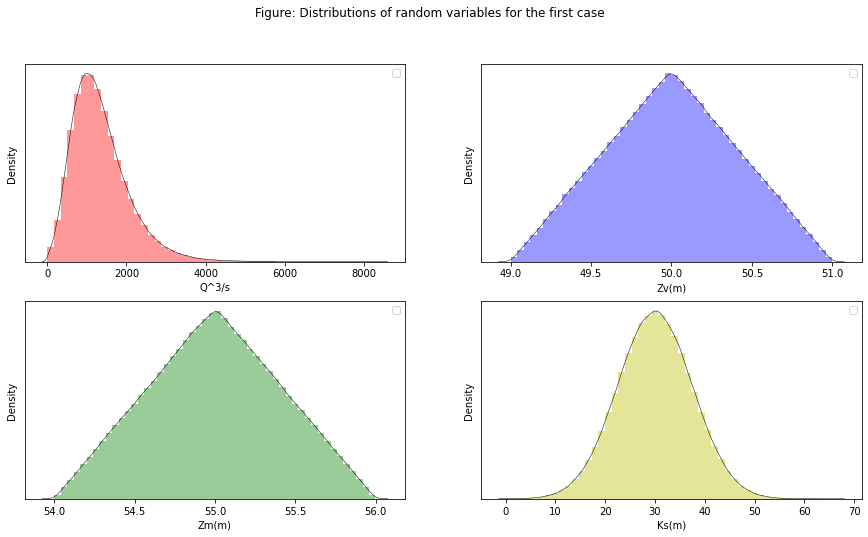

In [39]:
#first scenario

x=np.linspace(0.9,7.7,100)
fig, ax = plt.subplots(2,2,figsize=(15,8))

sns.distplot(q_realisations,ax=ax[0][0],color='r',kde_kws={"color": "k", "lw": 0.5})
ax[0][0].set_xlabel('Q^3/s')
ax[0][0].set_yticks([])
ax[0][0].legend()

sns.distplot(zv_realisations,ax=ax[0][1],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0][1].set_xlabel('Zv(m)')
ax[0][1].set_yticks([])
ax[0][1].legend()

sns.distplot(zm_realisations,ax=ax[1][0],color= 'g',kde_kws={"color": "k", "lw": 0.5})
ax[1][0].set_xlabel('Zm(m)')
ax[1][0].set_yticks([])
ax[1][0].legend()

sns.distplot(ks_realisations,ax=ax[1][1],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[1][1].set_xlabel('Ks(m)')
ax[1][1].set_yticks([])
ax[1][1].legend()

fig.suptitle('Figure: Distributions of random variables for the first case') 

plt.show()

3) Histogram of the samples collected for the second scenario

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose l

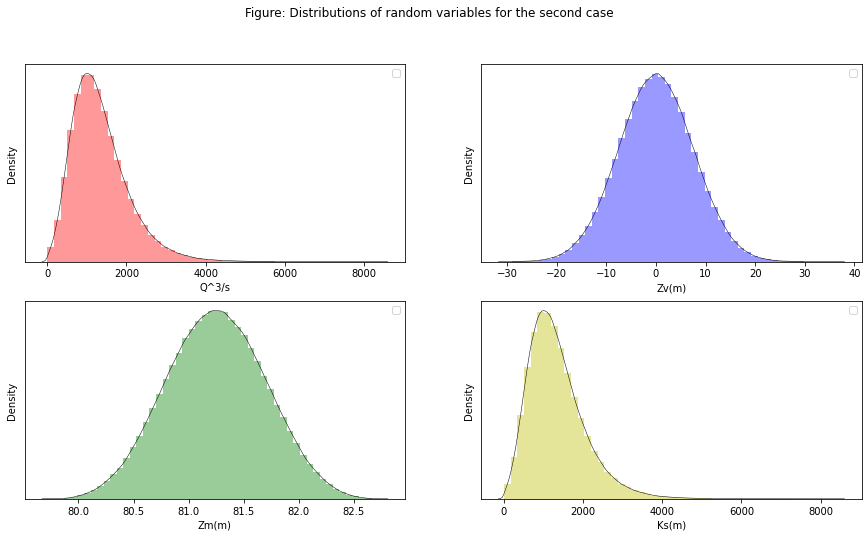

In [40]:
#second scenario

fig, ax = plt.subplots(2,2,figsize=(15,8))

sns.distplot(q_realisations,ax=ax[0][0],color='r',kde_kws={"color": "k", "lw": 0.5})
ax[0][0].set_xlabel('Q^3/s')
ax[0][0].set_yticks([])
ax[0][0].legend()

sns.distplot(realisations_2[:,1],ax=ax[0][1],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0][1].set_xlabel('Zv(m)')
ax[0][1].set_yticks([])
ax[0][1].legend()

sns.distplot(realisations_2[:,2],ax=ax[1][0],color= 'g',kde_kws={"color": "k", "lw": 0.5})
ax[1][0].set_xlabel('Zm(m)')
ax[1][0].set_yticks([])
ax[1][0].legend()

sns.distplot(realisations_2[:,0],ax=ax[1][1],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[1][1].set_xlabel('Ks(m)')
ax[1][1].set_yticks([])
ax[1][1].legend()

fig.suptitle('Figure: Distributions of random variables for the second case') 

plt.show()

4) Histogram of the samples collected for the third scenario

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose l

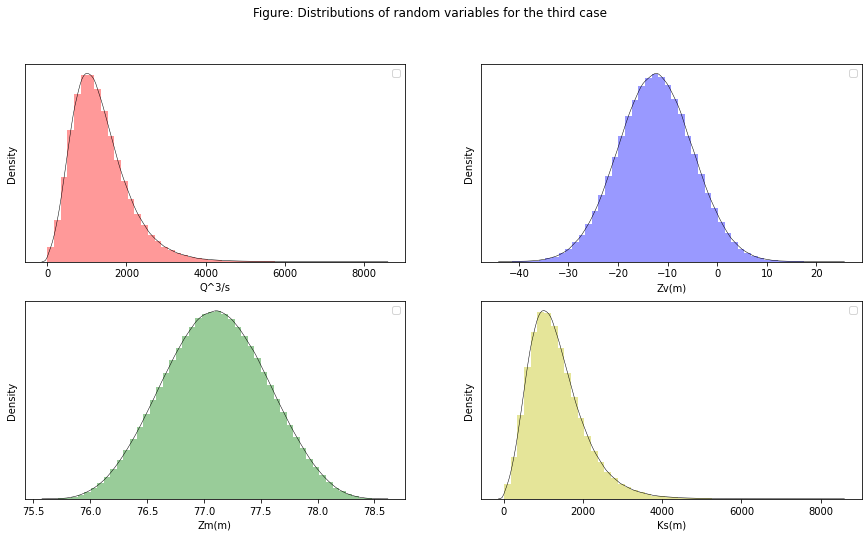

In [41]:
#third scenario

fig, ax = plt.subplots(2,2,figsize=(15,8))

sns.distplot(q_realisations,ax=ax[0][0],color='r',kde_kws={"color": "k", "lw": 0.5})
ax[0][0].set_xlabel('Q^3/s')
ax[0][0].set_yticks([])
ax[0][0].legend()

sns.distplot(realisations_3[:,1],ax=ax[0][1],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0][1].set_xlabel('Zv(m)')
ax[0][1].set_yticks([])
ax[0][1].legend()

sns.distplot(realisations_3[:,2],ax=ax[1][0],color= 'g',kde_kws={"color": "k", "lw": 0.5})
ax[1][0].set_xlabel('Zm(m)')
ax[1][0].set_yticks([])
ax[1][0].legend()

sns.distplot(realisations_3[:,0],ax=ax[1][1],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[1][1].set_xlabel('Ks(m)')
ax[1][1].set_yticks([])
ax[1][1].legend()

fig.suptitle('Figure: Distributions of random variables for the third case') 

plt.show()

5) In this block it's generated the equivalent H and S related to the samples of $Q$, $K_s$, $Z_m$ and $Z_v$ using the equations (1) and (2) and their histogram is shown. S represents the overflow in the facility and, to be able to model the height of the dike, we consider first $\mathcal{H}_d = 0$.

In [11]:
def generate_s_sample(sample:list,B=300,L=5000,Zb=55.5,hd=0):
    Q,Ks,Zv,Zm=sample[0],sample[1],sample[2],sample[3]
    strike_coef=np.power(np.multiply(Q,1/(B*np.multiply(Ks,np.sqrt((Zm-Zv)/L)))),3/5) 
    S=Zv+strike_coef+hd-Zb 
    return S, strike_coef

In [43]:
first_scenario=[q_realisations,ks_realisations,zv_realisations,zm_realisations]
second_scenario=[realisations_2[:,0],realisations_2[:,1],realisations_2[:,2],realisations_2[:,3]]
third_scenario=[realisations_3[:,0],realisations_3[:,1],realisations_3[:,2],realisations_3[:,3]]

first_scenario, H_1=generate_s_sample(first_scenario)
first_scenario=np.sort(first_scenario)
H_1=np.sort(H_1)
first_scenario=np.delete(first_scenario,np.isnan(first_scenario))

second_scenario, H_2=generate_s_sample(second_scenario)
second_scenario=np.sort(second_scenario)
H_2=np.sort(H_2)
second_scenario=np.delete(second_scenario,np.isnan(second_scenario),axis=0)

third_scenario, H_3=generate_s_sample(third_scenario)
third_scenario=np.sort(third_scenario)
H_3=np.sort(H_3)
third_scenario=np.delete(third_scenario,np.isnan(third_scenario),axis=0)

C:\Users\analu\AppData\Local\Temp\ipykernel_38780\2679847822.py:3: RuntimeWarning: invalid value encountered in sqrt
  strike_coef=np.power(np.multiply(Q,1/(B*np.multiply(Ks,np.sqrt((Zm-Zv)/L)))),3/5)


c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib

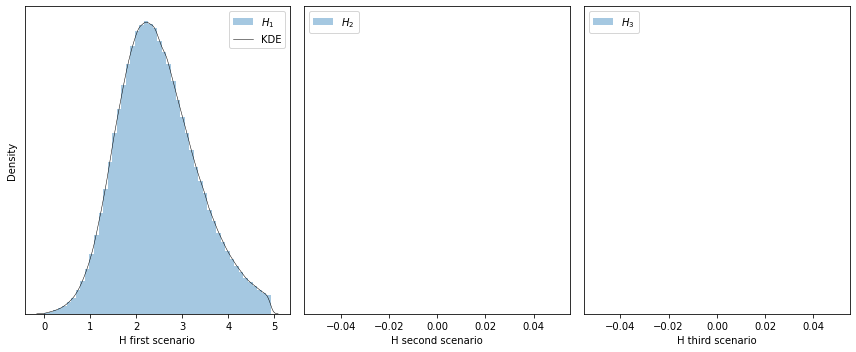

In [44]:
fig, ax = plt.subplots(1,3,figsize=(12,5))

sns.distplot(H_1[1:980000],ax=ax[0],label='$H_1$',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[0].set_yticks([])
ax[0].set_xlabel('H first scenario')
ax[0].legend()
sns.distplot(H_2[1:980000],ax=ax[1],label='$H_2$',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[1].set_yticks([])
ax[1].set_xlabel('H second scenario')
ax[1].legend()
sns.distplot(H_3[1:980000],ax=ax[2],label='$H_3$',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[2].set_yticks([])
ax[2].set_xlabel('H third scenario')
ax[2].legend()
plt.tight_layout()
# plt.savefig('Fig4.eps',format = 'eps')
plt.show()

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\

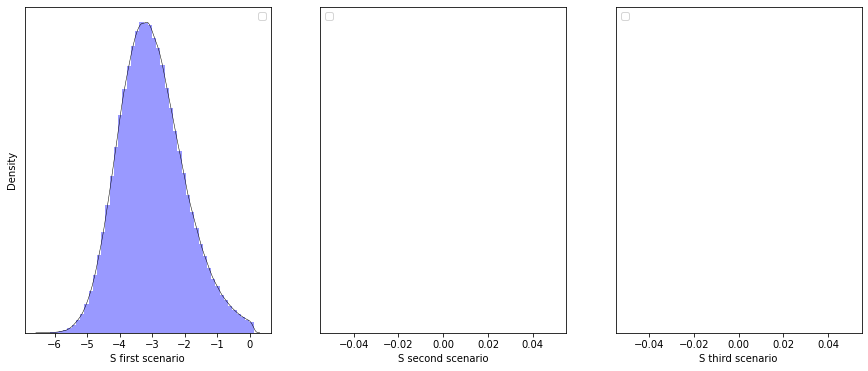

In [45]:
fig, ax = plt.subplots(1,3,figsize=(15,6))

sns.distplot(first_scenario[1:990000],ax=ax[0],color='b',kde_kws={"color": "k", "lw": 0.5})
ax[0].set_xlabel('S first scenario')
ax[0].set_yticks([])
ax[0].legend()

sns.distplot(second_scenario[1:990000],ax=ax[1],color='g',kde_kws={"color": "k", "lw": 0.5})
ax[1].set_xlabel('S second scenario')
ax[1].set_yticks([])
ax[1].legend()

sns.distplot(third_scenario[1:99000],ax=ax[2],color='y',kde_kws={"color": "k", "lw": 0.5})
ax[2].set_xlabel('S third scenario')
ax[2].set_yticks([])
ax[2].legend()

plt.show()

6) To be able to determine a parametric distribution for S in the first scenario, an Hypothesis test is carried for 3 candidates : Weibull, Gumbel and Normal. The parameters for the normal distribution are computed by the Maximum Likelihood Estimator method. Futhermore, for the other 2 distributions, the parameters are calculated by fitting function in the scipy.stats library.

    This hypothesis test analyses if the parametric distribution represents the distribution of dataset. In this step we are able to determinate an $\mathcal{H}_d$ correspondant to the 99% quantile using the empirical distribution and the deduced parametric distribution. It's used the $\chi^2$ hypothesis test and the most appropriate parametric distribution is chosen by the comparison of the quadratic error.

    Before implementing the fitting of the parametric law of S, the values of S are filtered to maintain only the positive values using the function delete_neg. As the negative values represents that there is no overflow and that the facility is safe, this manipulation is useful to properly describe the phenomena of interest. Another important remark is the exclusion of 0.5% of the biggest values of S because it's considered that these realisations are really unlikely to happen physically.

In [12]:
#function that delete the negative data
def delete_neg(data):
    data=np.sort(data)
    for i in range(len(data)):
        if (np.sign(data[i])*1)>0:
            cut = i
            break
    return data[cut:len(data)]

In [47]:
#alpha=0.995

first_scenario = delete_neg(first_scenario)
#first_scenario=first_scenario[0:int(len(first_scenario)*alpha)]

emp_mean = np.mean(first_scenario)
emp_stand_dev = np.std(first_scenario)


#computing the pvalue for the normal distribution using the chi2 test
n=100
df=n-2-1
hist_values = np.zeros(n)
for i in range(n):
    hist_values[i] = np.exp(np.log(11)*(i/n)**2)-1
#print(hist_values)
expon_cste = scp.stats.expon.fit(first_scenario)
hist_exp_cdf = scp.stats.expon.cdf(hist_values,expon_cste[0],expon_cste[1])
hist = np.zeros(n)
Tx = 0
erro = 0
hist_exp = np.zeros(n)
for i in range(len(hist_values)-1):
    hist[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_exp[i]=(hist_exp_cdf[i+1]-hist_exp_cdf[i])*len(first_scenario)
    Tx += (hist[i]-hist_exp[i])**2/hist_exp[i]
    erro+=(hist[i]-hist_exp[i])**2
print('p-value for exp(%s,%s) is %s' % (expon_cste[0],expon_cste[1],1-scp.stats.chi2.cdf(df,Tx)))
print('The quadratic error associated to the exponential distribution is %s' % erro) #quadratic error for the exponential distribution

#computing the pvalue for the weibull distribution using the chi2 test
weibull_cste = scp.stats.weibull_min.fit(first_scenario)
hist_wei_cdf = scp.stats.weibull_min.cdf(hist_values,weibull_cste[0],weibull_cste[1],weibull_cste[2])
hist2 = np.zeros(n)
Tx2 = 0
erro2 = 0
hist_wei = np.zeros(n)
for i in range(len(hist_values)-1):
    hist2[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_wei[i]=(hist_wei_cdf[i+1]-hist_wei_cdf[i])*len(first_scenario)
    Tx2 += (hist2[i]-hist_wei[i])**2/hist_wei[i]
    erro2 += (hist2[i]-hist_wei[i])**2
print('p-value for weibull(%s,%s) is %s' % (weibull_cste[0],weibull_cste[1],1-scp.stats.chi2.cdf(df-1,Tx2)))
print('The quadratic error associated to the weibull distribution is %s' % erro2) #quadratic error for the weibul distribution

#computing the pvalue for the gumbel distribution using the chi2 test
gumbell_cste = scp.stats.gumbel_r.fit(first_scenario)
hist_gum_cdf = scp.stats.gumbel_r.cdf(hist_values,gumbell_cste[0],gumbell_cste[1])
hist3 = np.zeros(n)
Tx3 = 0
erro3 = 0
hist_gum = np.zeros(n)
for i in range(len(hist_values)-1):
    hist3[i]=np.count_nonzero((first_scenario<hist_values[i+1]) & (first_scenario>=hist_values[i]))
    hist_gum[i]=(hist_gum_cdf[i+1]-hist_gum_cdf[i])*len(first_scenario)
    Tx3 += (hist3[i]-hist_gum[i])**2/hist_gum[i]
    erro3 += (hist3[i]-hist_gum[i])**2
print('p-value for gumbell(%s,%s) is %s' % (gumbell_cste[0],gumbell_cste[1],1-scp.stats.chi2.cdf(df,Tx3)))
print('The quadratic error associated to the gumbell distribution is %s' % erro3) #quadratic error for the gumbel distribution

h_d_empirical = np.quantile(first_scenario,0.99)
print('The chosen Hd from the empirical distribution is %s' % h_d_empirical)

if erro <= erro2 and erro <= erro3:
    h_d = scp.stats.expon.ppf(0.99,expon_cste[0],expon_cste[1])
    print('The parametric distribution with less error is exponential and the chosen Hd from the deduced parametric distribution is : %s'% h_d)
elif erro2 <= erro and erro2 <=erro3:
    h_d = scp.stats.weibull_min.ppf(0.99,weibull_cste[0],weibull_cste[1])
    print('The parametric distribution with less error is weibull and the chosen Hd from the deduced parametric distribution is : %s'% h_d)
else:
    h_d = scp.stats.gumbel_r.ppf(0.99,gumbell_cste[0],gumbell_cste[1])
    print('The parametric distribution with less error is gumbel and the chosen Hd from the deduced parametric distribution is : %s'% h_d)

p-value for $exp(1.5309820611264513e-06,0.8661869979326774)$ is 1.0
The quadratic error associated to the exponential distribution is 28669.29692381704
p-value for $weibull(0.9053578676972645,1.530982061126451e-06)$ is 1.0
The quadratic error associated to the weibull distribution is 16523.617862969597
p-value for $gumbell(0.48688559428716205,0.5539475101653879)$ is 1.0
The quadratic error associated to the gumbell distribution is 290155.9343309414
The chosen $\mathcal{H}_d$ from the empirical distribution is 5.256995888687382
The parametric distribution with less error is weibull and the chosen $\mathcal{H}_d$ from the deduced parametric distribution is : 5.4022987373794935


c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

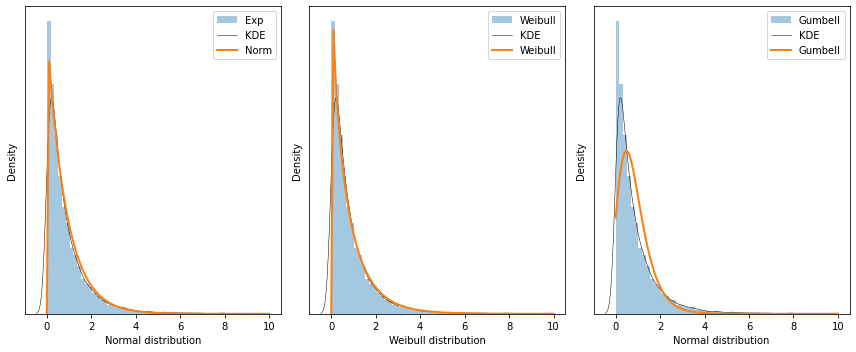

In [48]:
#plotting the histograms to undestand the comparison between the fitted distributions and the empirical one
x=np.linspace(0,10,100)
fig, ax = plt.subplots(1,3,figsize=(12,5))

sns.distplot(first_scenario,ax=ax[0],label='Exp',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[0].plot(x,scp.stats.expon.pdf(x,expon_cste[0],expon_cste[1]),\
         lw=2,label='Norm')
ax[0].set_yticks([])
ax[0].set_xlabel('Normal distribution')
ax[0].legend()
sns.distplot(first_scenario,ax=ax[1],label='Weibull',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[1].plot(x,scp.stats.weibull_min.pdf(x,weibull_cste[0],weibull_cste[1],weibull_cste[2]),\
         lw=2,label='Weibull')
ax[1].set_yticks([])
ax[1].set_xlabel('Weibull distribution')
ax[1].legend()
sns.distplot(first_scenario,ax=ax[2],label='Gumbell',kde_kws={"color": "k", "lw": 0.5, "label": "KDE"})
ax[2].plot(x,scp.stats.gumbel_r.pdf(x,gumbell_cste[0],gumbell_cste[1]),\
         lw=2,label='Gumbell')
ax[2].set_yticks([])
ax[2].set_xlabel('Normal distribution')
ax[2].legend()
plt.tight_layout()
# plt.savefig('Fig4.eps',format = 'eps')
plt.show()

8) In the previous steps, it was considered one simulation of 1 million samples to chose $\mathcal{H}_d$. But the choosen height of the dike is sensitive to the data used. To solve this issue, in the following development it's generated 10000 simulations with 1 million samples each. From this , we are able to deduce the distribution of the height of the dike $\mathcal{H}_d$ and make a better conclusion of the height of the dike and analyse it's sensibility.

    It's important to highlight that, in this part, we do not consider the parametric distribution from the hypothesis test analysis. Instead, the empirical 99% quantile is considered to be approximatively appropriate to determine $\mathcal{H}_d$ for each simulation.

[9.15651394 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[9.1565139

c:\Users\analu\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 9.15651394  7.45077189  8.89262068  8.36631018  8.36870291  7.82313021
  8.97144404  7.85661763  8.78028557  8.22628196  8.64394657  8.67361995
  7.86131827  8.53882411  7.94461065  8.53352858  8.94365949  9.67311316
  8.92140808  8.91418599  8.21039274  8.4140912   9.86866622  9.15378202
  8.81380712  8.89506525  8.19553825  8.74938156  8.4797075   9.3708502
  8.9976661   8.12800795  9.41346569  8.38807761  8.30618727  9.05842937
  9.14115253  8.75473066  9.06563638  8.12619471  9.51047894  8.69378477
  9.22436758  9.14619225  8.64852182  8.93615275  8.14616361  9.080691
 10.29511791  9.28214838  9.05996017  9.94322225  8.60139177  8.64377018
  8.77678874  9.67155836  9.31588349  8.77409014  8.83862677  8.40896275
  9.06134688  9.00635816  9.18536643  9.63376078  8.77016886  8.67342742
  9.2671011   8.137607    8.99126695  9.07623094 10.26693722  9.17083752
  8.68145481  8.00186065  8.2740735   7.92369829  8.76863775  9.75464226
  9.23412655 10.07822631  9.00998022  8.61701934  8.32

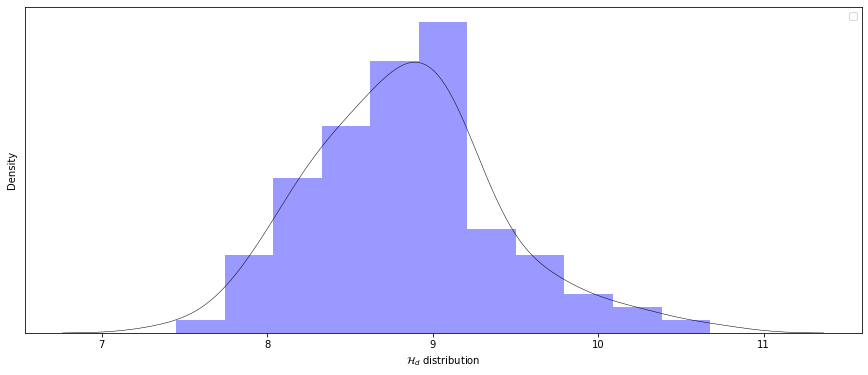

In [20]:
N_simulations = 100
N_sample = 1000000

#function that compute the vector h_d of the chosen height of the dike for N_sim simulations
def multiple_simulations(N_sim, N_samples):
    S_1 = np.zeros(N_samples)
    H_1 = np.zeros(N_samples)
    h_d = np.zeros(N_sim)
    for i in range(N_sim):
        sample = generate_sample(N_samples)
        S_1, H_1 = generate_s_sample([sample[0],sample[1],sample[2],sample[3]])
        S_1 = np.sort(S_1)
        H_1 = np.sort(H_1)
        S_1 = S_1[S_1>0]
        S_1 = S_1[0:int(len(S_1)*0.995)]
        h_d[i] = np.quantile(S_1,0.9999)
        print(h_d)
    return h_d

h_d = multiple_simulations(N_simulations,N_sample) #generating the heights correspondent to the 10.000 simulations

#plotting the histogram of h_d for 10.000 simulations
plt.figure(figsize=(15,6))
sns.distplot(h_d,color='b',kde_kws={"color": "k", "lw": 0.5})
plt.xlabel('$\mathcal{H}_d$ distribution')
plt.yticks([])
plt.legend()

In [19]:
h_d_final = np.mean(h_d)
print(h_d_final)

8.83716318595526
